In [1]:
import numpy as np
import pandas as pd
from pytmle import PyTMLE

In [2]:
target_times = [1.0, 2.0, 3.0, 4.0, 5.0]
np.random.seed(42)

Load a mock dataset with n_samples and two events 1 and 2, in which both group partly depends on x1, x2 and x3, and event_indicator partly depends on group, x1 and x3.

In [3]:
df = pd.read_csv("data.csv", index_col=0)

Define a custom model (exemplified by a model based on DeepSurv) to be cross-fitted in the .fit method.

In [4]:
# DeepSurv does not support competing risks
df["event_indicator"] = (df["event_indicator"] == 1).astype(int)

In [5]:
# imports needed for pycox
import torchtuples as tt
from pycox.models import CoxPH

in_features = 4 # x1, x2, x3, group
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model = CoxPH(net, tt.optim.Adam)

Instantiate the PyTMLE class and fit it with the DeepSurv model as initial estimator.

In [6]:
tmle_deepsurv = PyTMLE(df, 
              col_event_times="event_time", 
              col_event_indicator="event_indicator", 
              col_group="group", 
              target_times=target_times, 
              g_comp=True,
              verbose=False,)

tmle_deepsurv.fit(cv_folds=5, 
         max_updates=100, 
         save_models=True,
         model=model,
         labtrans=None)

INFO:pytmle.pytmle:Estimating propensity scores...
INFO:pytmle.pytmle:Estimating hazards and event-free survival...
INFO:pytmle.pytmle:Estimating censoring survival...
INFO:pytmle.pytmle:Starting TMLE update loop...
INFO:pytmle.tmle_update:TMLE converged at step 24.


Alternatively, it is also possible to use models from scikit-survival, like the random survival forest.

In [7]:
from sksurv.ensemble import RandomSurvivalForest

tmle_rsf = PyTMLE(df, 
              col_event_times="event_time", 
              col_event_indicator="event_indicator", 
              col_group="group", 
              target_times=target_times, 
              g_comp=True,
              verbose=False,)

tmle_rsf.fit(cv_folds=5, 
         max_updates=100, 
         save_models=True,
         model=RandomSurvivalForest(),
         labtrans=None)

INFO:pytmle.pytmle:Estimating propensity scores...
INFO:pytmle.pytmle:Estimating hazards and event-free survival...
INFO:pytmle.pytmle:Estimating censoring survival...
INFO:pytmle.pytmle:Starting TMLE update loop...
INFO:pytmle.tmle_update:TMLE converged at step 19.


(<Figure size 1400x700 with 1 Axes>,
 [<Axes: title={'center': 'Event 1'}, xlabel='Time', ylabel='Predicted Risk'>])

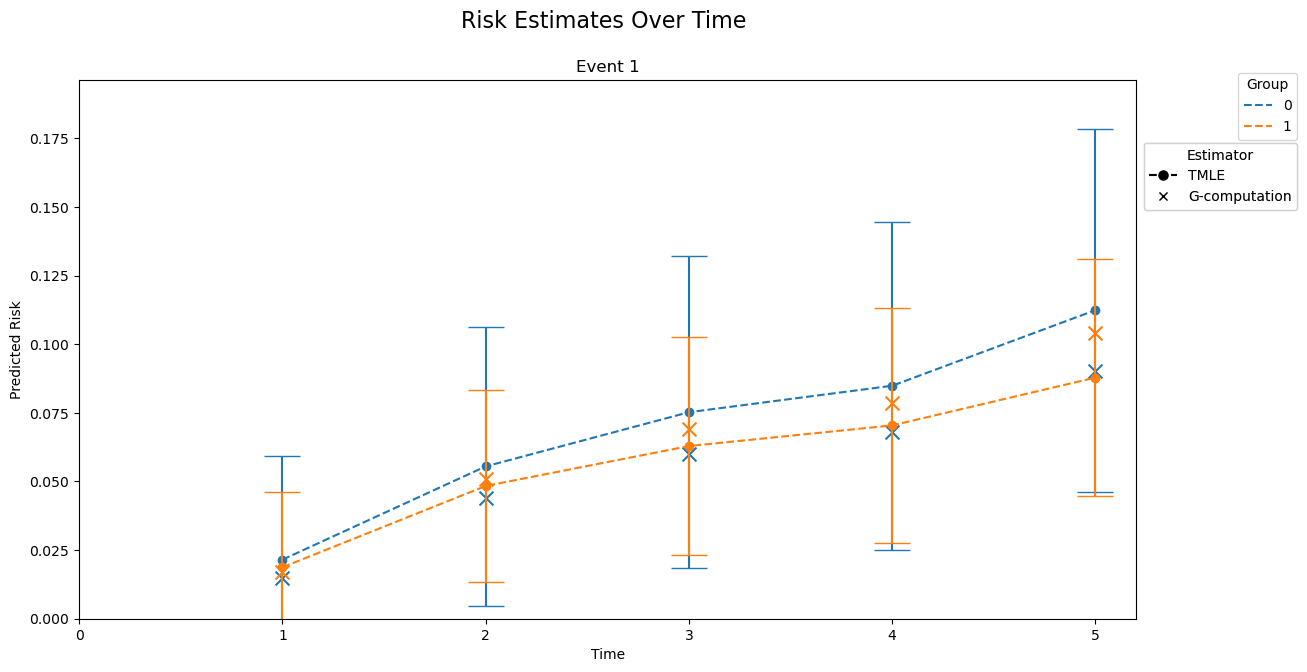

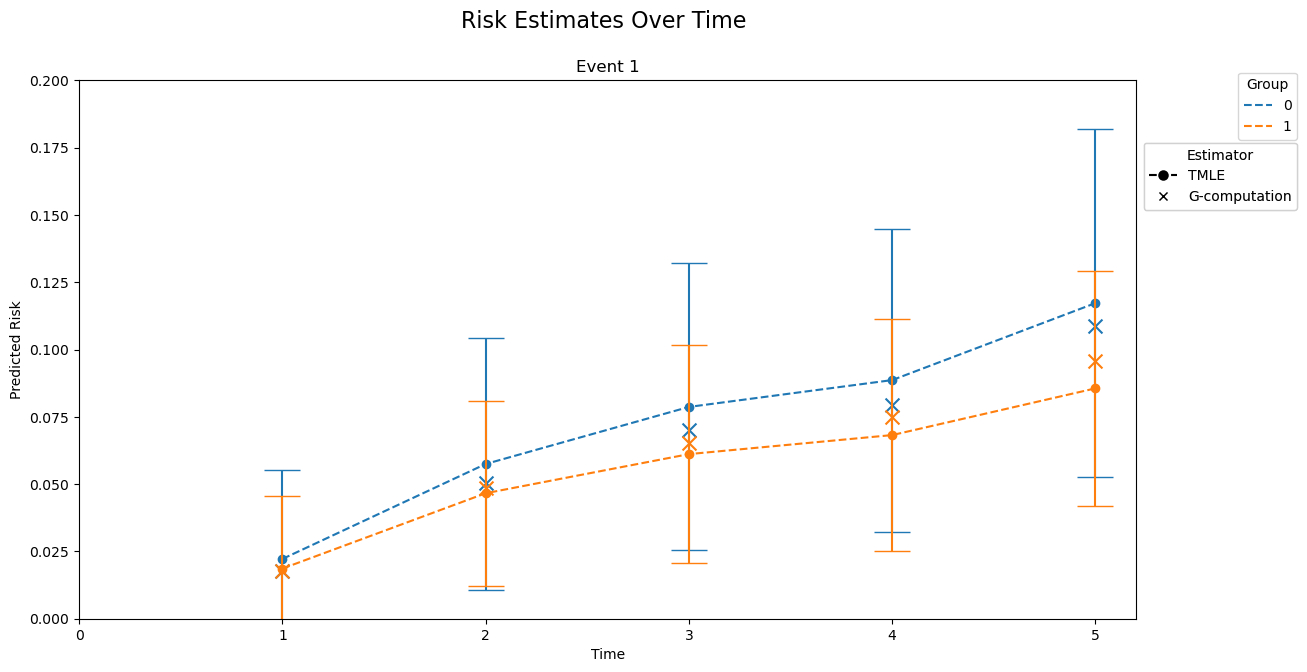

In [8]:
tmle_deepsurv.plot(g_comp=True, use_bootstrap=False)
tmle_rsf.plot(g_comp=True, use_bootstrap=False)

Since `save_models` was set to `True` in the `fit()` call, you can extract the models used for initial estimates and analyze them further. Note that all cross-fitted models are of type `PycoxWrapper` and only return the name of the wrapped class.

In [9]:
print(tmle_deepsurv.models)
print(tmle_rsf.models)

{'propensity_model': StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier()),
                               ('gb', GradientBoostingClassifier())],
                   final_estimator=LogisticRegression(max_iter=1000)), 'risk_model_fold_0': CoxPH, 'risk_model_fold_1': CoxPH, 'risk_model_fold_2': CoxPH, 'risk_model_fold_3': CoxPH, 'risk_model_fold_4': CoxPH, 'censoring_model_fold_0': CoxPH, 'censoring_model_fold_1': CoxPH, 'censoring_model_fold_2': CoxPH, 'censoring_model_fold_3': CoxPH, 'censoring_model_fold_4': CoxPH}
{'propensity_model': StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier()),
                               ('gb', GradientBoostingClassifier())],
                   final_estimator=LogisticRegression(max_iter=1000)), 'risk_model_fold_0': RandomSurvivalForest, 'risk_model_fold_1': RandomSurvivalForest, 'risk_model_fold_2': RandomSurvivalForest, 'risk_model_fold_3': RandomSurvivalForest, 'risk_model_fold_4'